# Importing Modules

In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.constants import mu_0
from scipy.constants import physical_constants
import matplotlib
import matplotlib.pyplot as plt

import data_tests_functions as dtf

matplotlib.rcParams.update({'font.size': 14})

print('Importing done.')

Importing done.


In [2]:
def round_to_significant_digits(value, sig_digits):
    """
    Rounds a value to a specified number of significant digits.
    :param value: The value to round.
    :param sig_digits: The number of significant digits to round to.
    :return: The rounded value.
    """
    if value == 0:
        raise ValueError("Cannot round a value of 0 to significant digits.")
    digits = -int(np.floor(np.log10(abs(value))) - (sig_digits - 1))
    value_rounded = round(value, digits)
    return value_rounded

# Data directory input

In [3]:
data_dir = '/Users/santapile/Santas/Projects/MaMMoS/NOMAD/dataExamples/UU/UU-sets/Fe3-xTaxY_x0_22'

In [4]:
import check_file_and_folder_structure as cffs
cffs.check_structure(data_dir, check_README=True, verbose=True)

False

In [5]:
data_dir_GS = data_dir + "/GS"
data_dir_MC = data_dir + "/MC"

xyz_dirs = [dirdir for dirdir in os.listdir(data_dir_GS) if len(dirdir) == 1]

print(data_dir_GS)
print(data_dir_MC)
print(xyz_dirs)

/Users/santapile/Santas/Projects/MaMMoS/NOMAD/dataExamples/UU/UU-sets/Fe3-xTaxY_x0_22/GS
/Users/santapile/Santas/Projects/MaMMoS/NOMAD/dataExamples/UU/UU-sets/Fe3-xTaxY_x0_22/MC
['z', 'x']


# Magnetization

In [6]:
# Reading file into lines; all folders are equivalent according to UU-colleagues, so we can use the first one
file_Name_Ms = data_dir_GS + f"/{xyz_dirs[0]}/out_last"
print(file_Name_Ms)

# Create dicts with orbital IDs and values of corresponding
# Total moment and its direction (+/-1)
tot_moments_D = dtf.find_line_val_dict(file_Name_Ms, 'Total moment [J=L+S] (mu_B):')
dir_of_JD = dtf.find_line_val_dict(file_Name_Ms, 'Direction of J (Cartesian):')
# print("tot_moments_D:"+str(tot_moments_D))
# print("dir_of_JD:"+str(dir_of_JD))
params_merged = {}
for key in tot_moments_D.keys():
    params_merged[key] = tot_moments_D[key] + dir_of_JD[key]

# Pretty table for checking the entries for magnetic moments and directions
df = pd.DataFrame.from_dict(params_merged, orient='index',
                            columns = ['J=L+S (Cartesian)',
                                       'J=L+S (Spin axis)',
                                       'Direction of J (x)',
                                       'Direction of J (y)',
                                       'Direction of J (z)'])
df

/Users/santapile/Santas/Projects/MaMMoS/NOMAD/dataExamples/UU/UU-sets/Fe3-xTaxY_x0_22/GS/z/out_last


,J=L+S (Cartesian),J=L+S (Spin axis),Direction of J (x),Direction of J (y),Direction of J (z)
ID:0102010100-o,0.239113,0.239113,4.400000e-07,-2.700000e-07,-1.000000
ID:0101010100-o,0.020878,0.020878,-2.100000e-07,1.100000e-07,-1.000000
ID:0100010100-o,0.009247,0.009247,-3.000000e-08,0.000000e+00,-1.000000
ID:0202010100-o,0.239113,0.239113,4.500000e-07,-2.700000e-07,-1.000000
ID:0201010100-o,0.020878,0.020878,-2.000000e-07,1.200000e-07,-1.000000
...,...,...,...,...,...
ID:3501010100-o,0.022594,0.022594,-1.195028e-02,-6.899670e-03,-0.999905
ID:3500010100-o,0.002232,0.002232,-1.762899e-02,-1.017728e-02,0.999793
ID:3602010100-o,1.652269,1.652269,2.927250e-03,1.689930e-03,0.999994
ID:3601010100-o,0.022594,0.022594,-1.195102e-02,-6.899810e-03,-0.999905


## Calculating magnetization
**Use:** Cartesian (with direction) - we should use that</br>
Spin axis coordinates we ignore

In [7]:
# Calculating total magnetic moment by summing all
# (Total moment (of an orbital) * Direction of J (takes the one with abs value > 0.9, should be +/-1))
tot_magn_mom_C = 0
for key in tot_moments_D.keys():
    tot_magn_mom_C += tot_moments_D[key][0]*[x for x in dir_of_JD[key] if abs(x) > 0.9][0]
    print(key, ': ', tot_moments_D[key][0], '*', 
          [x for x in dir_of_JD[key] if abs(x) > 0.9][0], '=', 
          tot_moments_D[key][0]*[x for x in dir_of_JD[key] if abs(x) > 0.9][0])
    #    total magnetic moment J=L+S * orientation, wherever +/-1 is

print(f'\nTotal magnetic moment = {tot_magn_mom_C}')

# Getting unit cell volume in A^3 from the file
ucv = dtf.find_line_val_dict(file_Name_Ms, 'unit cell volume:')
print(ucv)
# Recalculating in=t in angstroms (should be transferred to m afterwards)
ucvA = ucv[list(ucv.keys())[0]][0] / 1.8897259**3 # unit cell volume in A
print(f'Unit cell volume: {ucvA} A\N{SUPERSCRIPT THREE}')

# Calculating magnetization in Tesla
magnetization_in_T = tot_magn_mom_C/ucvA*11.654
print(f'Magnetization Ms: {magnetization_in_T} T')

ID:0102010100-o :  0.2391128 * -1.0 = -0.2391128
ID:0101010100-o :  0.02087817 * -1.0 = -0.02087817
ID:0100010100-o :  0.009247159 * -1.0 = -0.009247159
ID:0202010100-o :  0.2391127 * -1.0 = -0.2391127
ID:0201010100-o :  0.02087818 * -1.0 = -0.02087818
ID:0200010100-o :  0.009247152 * -1.0 = -0.009247152
ID:0302010100-o :  0.2391099 * -1.0 = -0.2391099
ID:0301010100-o :  0.02087817 * -1.0 = -0.02087817
ID:0300010100-o :  0.009247143 * -1.0 = -0.009247143
ID:0402010100-o :  0.2391097 * -1.0 = -0.2391097
ID:0401010100-o :  0.02087793 * -1.0 = -0.02087793
ID:0400010100-o :  0.009247167 * -1.0 = -0.009247167
ID:0502010100-o :  0.2391095 * -1.0 = -0.2391095
ID:0501010100-o :  0.02087793 * -1.0 = -0.02087793
ID:0500010100-o :  0.009247153 * -1.0 = -0.009247153
ID:0602010100-o :  0.2391098 * -1.0 = -0.2391098
ID:0601010100-o :  0.02087817 * -1.0 = -0.02087817
ID:0600010100-o :  0.009247133 * -1.0 = -0.009247133
ID:0702010100-o :  0.06836692 * -1.0 = -0.06836692
ID:0701010100-o :  0.00723947 *

### Q&A
**Question #1:** Why doubled data for each orbital? </br>
<b>Answer #1:</b> because calculations may run several times, that's why we need to take the last one

**Question #2:** How do we calculate total magnetic moment? (Does direction matter?) </br>
<b>Answer #2:</b> the direction does matter. For testing approximate resulting value of Ms should be in the README file, our result should be in 2% range of it

# Anisotropy

In [8]:
energies = {}

if f'out_MF_{xyz_dirs[0]}' in os.listdir(data_dir_GS+f'/{xyz_dirs[0]}'):
    for dirdir in xyz_dirs:
        fileName = data_dir_GS+f"/{dirdir}/out_MF_{dirdir}"
        eigenvalue_sum = dtf.find_line_val_dict(fileName, 'Eigenvalue sum:')
        energies[dirdir] = eigenvalue_sum[list(eigenvalue_sum.keys())[0]][0]
elif f'out_Etot_{xyz_dirs[0]}' in os.listdir(data_dir_GS+f'/{xyz_dirs[0]}'):
    for dirdir in xyz_dirs:
        fileName = data_dir_GS+f"/{dirdir}/out_Etot_{dirdir}"
        energies[dirdir] = dtf.get_energy_from_file(fileName)
else:
    print('no files for anisotropy')

allKs = list()
if 'z' in energies.keys():
    if 'x' in energies.keys():
        Kxz = (energies['x'] - energies['z'])/ucvA*2179874
        allKs.append(Kxz)
    if 'y' in energies.keys():    
        Kyz = (energies['y'] - energies['z'])/ucvA*2179874
        allKs.append(Kyz)

K = max(allKs) * 1e6            # anisotropy J/m³

print(f'Anisotropy constant (max of all): {K} J/m\N{SUPERSCRIPT THREE}')

Anisotropy constant (max of all): 2173977.8944626446 J/m³


# Exchange

[ 10.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400. 420. 440. 460. 480. 500. 520. 540.
 560. 580. 600. 620. 640. 660. 680. 700. 720. 740. 760. 780. 800.]
There seem to be NO momfile and no posfile :( Getting n_atoms from GS/out_last
Number of atoms: 36
Tc = 560.0 K
1.1525681415599256 2.125209440498841
spin wave stiffness constant  1.0897681294693933e-40
exchange constant at T=0 2.6944076039194074e-12
Js_300 (T) 0.8513763223383353
A_300 (J/m) 1.4701891359415733e-12
K_300 (MJ/m) 0.8762337851418068
1.4701891359415733e-12
0.8513763223383353
Lex  1.5965038446976825


/Users/santapile/Santas/DataAnalysis/nomad/data_preview/data_tests_functions.py:34: RuntimeWarning: invalid value encountered in power
  return M_0 * (1 - s * (T / T_C) ** (3 / 2) - (1 - s) * (T / T_C) ** p) ** beta


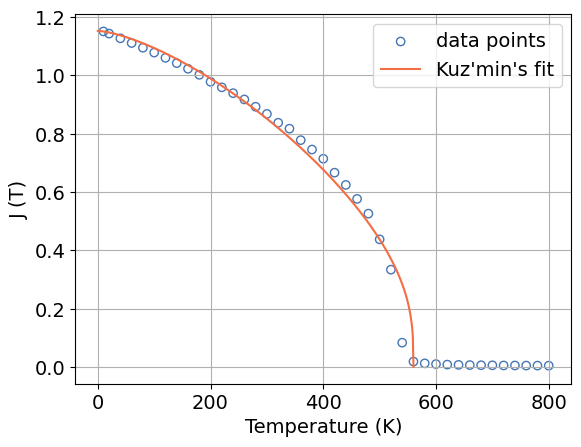

In [9]:
# Define the form of the function you want to fit
fn = data_dir_MC + '/M(T)'  # magnetic polarization
TK, Js = dtf.read_2_col_data(fn)
print(TK)

mc_dirs = [dirdir for dirdir in os.listdir(data_dir_MC) if dirdir in ['momfile', 'posfile']]

if len(mc_dirs) > 0:
    with open(data_dir_MC + '/' + mc_dirs[0], 'rt') as f:
        n_atoms = len(f.read().splitlines())
    print(f'Number of atoms: {n_atoms}')
else:
    print('There seem to be NO momfile and no posfile :( Getting n_atoms from GS/out_last')
    atoms_Ns = set([int(key[key.find(':')+1:key.find(':') + 3]) for key in tot_moments_D.keys()])
    n_atoms = len(atoms_Ns)
print(f'Number of atoms: {n_atoms}')
    
Js = [item*n_atoms/ucvA*11.654 for item in Js]

poscut = np.argmin(np.diff(Js)/np.diff(TK))+2
Tc = TK[poscut]
print(f'Tc = {Tc} K')
TKc = TK[:poscut].copy()
Jsc = Js[:poscut].copy()

xfine = np.linspace(0, Tc, 500)
p    = 5.0 / 2
beta = 1. / 3
m_s = partial(dtf.spontaneous_magnetization, p=p, beta=beta, T_C=Tc)

popt, pcov = curve_fit(m_s, TKc, Jsc)
Js_0, s = popt
print(Js_0, s)
T_fit = np.linspace(min(TKc), max(TKc), 500)
Js_fit = m_s(T_fit, Js_0, s)

g = 2
k_b = physical_constants["Boltzmann constant"][0]
mu_b = physical_constants["Bohr magneton"][0]

M_0 = Js_0/mu_0
D = (0.1509
     * ((g * mu_b) / (s * beta * M_0)) ** (2. / 3)
     * k_b
     * Tc
     )
print("spin wave stiffness constant ",D)
A_0 = M_0 * D / (2 * g * mu_b)
print("exchange constant at T=0",A_0)

Js_300 = m_s(300., Js_0, s)
print("Js_300 (T)",Js_300)

A_300 = A_0*(Js_300/Js_0)**2
print("A_300 (J/m)",A_300)

K_300 = K*(Js_300/Js_0)**3
print("K_300 (MJ/m)",K_300/1e6)

# A = A_0*(Js/Js0)^2
print(A_300)
print(Js_300)
print('Lex ',np.sqrt(mu_0*A_300/(Js_300*Js_300))/1e-9)

fig, ax = plt.subplots()
ax.scatter(TK, Js, marker="o", label="data points", facecolors='none', edgecolors='#4575b4')
label = "Kuz'min's fit"
ax.plot(xfine, m_s(xfine, Js_0, s), label=label, color='#f46d43')
ax.legend()
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("J (T)")
ax.grid()

### Data from README file for doublechecking

In [10]:
import re

# Ms - Saturation Magnetization
# MAE - Magnetic Anisotropy Energy
with open(data_dir + '/README', 'rt') as f:
    print("### README:")
    print(f.read())
    print("### End of README\n")
    # Extract the value for Ms from README
    with open(data_dir + '/README', 'rt') as f:
        readme_content = f.read()

    ms_match = re.search(r'Ms\s*=\s*([\d.]+)\s*T', readme_content)
    if ms_match:
        ms_value_in_T = float(ms_match.group(1))
        print(f"Extracted Ms value from README: {ms_value_in_T} T")
    else:
        print("Ms value not found in README")

    mae_matches = re.findall(r'([xyz])\s*-\s*([xyz])\s*=\s*([\d.]+)\s*MJ/m³', readme_content)
    if mae_matches:
        mae_values_in_MJPerCubicm = [float(match[2]) for match in mae_matches]
        max_mae_value_in_MJPerCubicm = max(mae_values_in_MJPerCubicm)
        print(f"Extracted maximum MAE value from README: {max_mae_value_in_MJPerCubicm} MJ/m³")
    else:
        print("MAE values not found in README")

### README:
Ms = 0.6477 T
MAE= 2.17 MJ/m³

### End of README

Extracted Ms value from README: 0.6477 T
MAE values not found in README


### Summary of values computed from the dataset

In [11]:
print(" Ms = "+str(round_to_significant_digits(magnetization_in_T, 4)) + " T")
print(" K = " + str(round_to_significant_digits(K/1e6, 4)) + " MJ/m^3")

 Ms = 0.6477 T
 K = 2.174 MJ/m^3


### Computing deviations between computed values and given values from the README

In [12]:
deviation_in_percent = 100 - (magnetization_in_T/ ms_value_in_T) * 100
print(" Deviation for magnetization in percent = "+str(round_to_significant_digits(deviation_in_percent, 4)) + " %")

 Deviation for magnetization in percent = -0.004042 %


In [13]:
deviation_mae_percent = 100 - ((K/1e6) / max_mae_value_in_MJPerCubicm) * 100
print(" Deviation for anisotropy energy/constant in percent = " + str(round_to_significant_digits(deviation_mae_percent, 4)) + " %")

NameError: name 'max_mae_value_in_MJPerCubicm' is not defined

In [ ]:
atoms_Ns = set([int(key[key.find(':')+1:key.find(':') + 3]) for key in tot_moments_D.keys()])
len(atoms_Ns)

In [ ]:
set([1,1,2,3])

In [ ]:
np.loadtxt(fn)